# SBA Loan: Building and Validating the Model 

This notebook follows the structure of the article [*“Should This Loan be Approved or Denied?”*](https://doi.org/10.1080/10691898.2018.1434342) and walks through the key steps of **Building the Model**, **Choosing a Decision Rule**, and **Validating the Logistic Regression Model** to assess loan approval decisions based on risk.

In [1]:
# IMPORTS
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy.stats import chi2
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from Utils.stats import Stats
from Utils.plots import Plotter as Plot
from Utils.tables import TableBuilder as Table

In [2]:
df = pd.read_csv(r'Data\SBAcase.csv')
print(df.shape)
df.head().T

(2102, 35)


0                        1  \
Selected                                  0                        1   
LoanNr_ChkDgt                    1004285007               1004535010   
Name               SIMPLEX OFFICE SOLUTIONS        DREAM HOME REALTY   
City                                ANAHEIM                 TORRANCE   
State                                    CA                       CA   
Zip                                   92801                    90505   
Bank                CALIFORNIA BANK & TRUST  CALIFORNIA BANK & TRUST   
BankState                                CA                       CA   
NAICS                                532420                   531210   
ApprovalDate                          15074                    15130   
ApprovalFY                             2001                     2001   
Term                                     36                       56   
NoEmp                                     1                        1   
NewExist                                1.0                      1.0   
CreateJob                                 0                        0   
RetainedJob                               0                        0   
FranchiseCode                             1                        1   
UrbanRural                                0                        0   
RevLineCr                                 Y                        Y   
LowDoc                                    N                        N   
ChgOffDate                              NaN                      NaN   
DisbursementDate                    15095.0                  15978.0   
DisbursementGross                     32812                    30000   
BalanceGross                              0                        0   
MIS_Status                            P I F                    P I F   
ChgOffPrinGr                              0                        0   
GrAppv                                30000                    30000   
SBA_Appv                              15000                    15000   
New                                       0                        0   
RealEstate                                0                        0   
Portion                                 0.5                      0.5   
Recession                                 0                        1   
daysterm                               1080                     1680   
xx                                  16175.0                  17658.0   
Default                                   0                        0   

                                               2                        3  \
Selected                                       0                        1   
LoanNr_ChkDgt                         1005005006               1005535001   
Name               Winset, Inc. dba Bankers Hill         Shiva Management   
City                                   SAN DIEGO                SAN DIEGO   
State                                         CA                       CA   
Zip                                        92103                    92108   
Bank                     CALIFORNIA BANK & TRUST  CALIFORNIA BANK & TRUST   
BankState                                     CA                       CA   
NAICS                                     531210                   531312   
ApprovalDate                               15188                    15719   
ApprovalFY                                  2001                     2003   
Term                                          36                       36   
NoEmp                                         10                        6   
NewExist                                     1.0                      1.0   
CreateJob                                      0                        0   
RetainedJob                                    0                        0   
FranchiseCode                                  1                        1   
UrbanRural                                     0               

## Building The Model
### Initial Model
On initial predictors: `New`, `RealEstate`, `DisbursementGross`, `Portion`, `Recession`:
- Split data into train/test.
- Add constant.
- Fit logistic regression and summarize.
- Perform Type III test.

In [3]:
# INITIAL MODEL
# Train/Test split -- selected = 1 = training data
train = df[df['Selected'] == 1].copy()
test = df[df['Selected'] == 0].copy()

In [4]:
# Initial predictors and target
predictors_initial = ['New','RealEstate','DisbursementGross','Portion','Recession']
X_train_init = train[predictors_initial]
X_train_init = sm.add_constant(X_train_init)
y_train = train['Default']

In [5]:
# Initial fit and results
model_init = sm.Logit(y_train, X_train_init)
result_init = model_init.fit()
result_init.summary()

Optimization terminated successfully.
         Current function value: 0.514605
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1045
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Aug 2025   Pseudo R-squ.:                  0.1740
Time:                        05:47:26   Log-Likelihood:                -540.85
converged:                       True   LL-Null:                       -654.77
Covariance Type:            nonrobust   LLR p-value:                 3.112e-47
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3537      0.323      4.192      0.000       0.721       1.987
New                  -0.0772      0.210     -0.367      0.713      -0.489       0.335
RealEstate           -2.0331      0.364     -5.592      0.000      -2.746      -1.320
DisbursementGross -3.371e-07   3.52e-07     -0.958      0.338   -1.03e-06    3.53e-07
Portion              -2.8298      0.559     -5.059      0.000      -3.926      -1.733
Recession             0.4971      0.241      2.060      0.039       0.024       0.970
=====================================================================================
"""

In [6]:
type3 = Stats.type3_test('Default', predictors_initial, train)
type3

Variable  DF  Chi-Square  Pr > ChiSq
0                New   1        0.14      0.7130
1         RealEstate   1       39.96      0.0000
2  DisbursementGross   1        0.97      0.3258
3            Portion   1       27.41      0.0000
4          Recession   1        4.27      0.0389

**Logit Regression Results**

The logistic regression model explains about 17% of the variation in loan default.  
- `RealEstate`: Loans secured by real estate have a much lower probability of default.  
- `Portion`: Higher SBA guarantee ratios are associated with lower default probability.  
- `Recession`: Loans issued during a recession are more likely to default.  
- `New` and `DisbursementGross` do not show a meaningful effect once other variables are considered.

**Type 3 Test results:**
- `RealEstate` and `Portion` are highly significant, meaning they strongly affect default probability.
- `Recession` is mildly significant.
- `New` and `DisbursementGross` are not significant, so they may not contribute meaningfully once other variables are included.

### Final Model
Train and fit on significant predictors: `RealEstate`, `Portion` and `Recession`.

In [7]:
# Final model train fit
predictors_final = ['RealEstate', 'Portion', 'Recession']
X_final = train[predictors_final]
X_final = sm.add_constant(X_final)
y_final = train['Default']

model_final = sm.Logit(y_final, X_final)
result_final = model_final.fit()
logreg_summary = result_final.summary()
logreg_summary

Optimization terminated successfully.
         Current function value: 0.515108
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1047
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Aug 2025   Pseudo R-squ.:                  0.1732
Time:                        05:47:28   Log-Likelihood:                -541.38
converged:                       True   LL-Null:                       -654.77
Covariance Type:            nonrobust   LLR p-value:                 6.874e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3931      0.322      4.332      0.000       0.763       2.023
RealEstate    -2.1282      0.345     -6.169      0.000      -2.804      -1.452
Portion       -2.9875      0.539     -5.540      0.000      -4.044      -1.931
Recession      0.5041      0.241      2.090      0.037       0.031       0.977
==============================================================================
"""

**Changes in results:**
- **Model fit:** Pseudo R² remained nearly unchanged (0.174 → 0.173), indicating no meaningful loss in explanatory power.
- **Log-Likelihood:** Slight change from -540.85 to -541.38 despite removing 2 predictors, confirming they contributed little.
- **Significance:** The remaining predictors retained their effect sizes and statistical significance.

Dropping non-significant variables simplified the model without reducing predictive strength, improving interpretability.

## CHOOSING A DECISION RULE
- Use final true labels (y_final) and predicted probabilities.
- Define a range of cutoff probability thresholds from 0.01 to 0.75.
- Calculate misclassification rates for each cutoff.
- Plot misclassification rate against cutoff probability to find the optimal threshold.

In [8]:
# DECISION RULE
y_true = y_final
y_prob = result_final.predict(X_final)
cutoffs = np.arange(0.01, 0.76, 0.02)

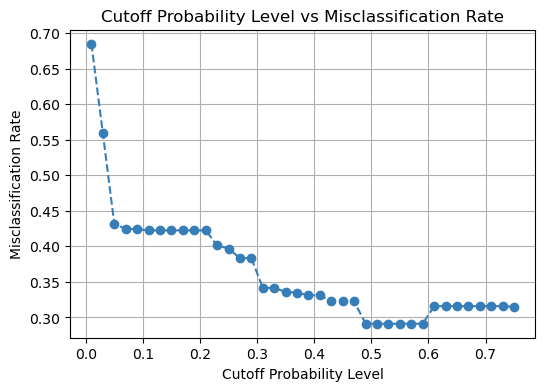

In [9]:
misclass_rates = Stats.get_misclass_rates(cutoffs, y_prob, y_true)
fig_misclass_vs_cutoff = Plot.plot_threshold_perf(
    cutoffs,
    misclass_rates,
    x_label = 'Cutoff Probability Level',
    y_label= 'Misclassification Rate',
    title = 'Cutoff Probability Level vs Misclassification Rate'
)

- At very low cutoffs, the misclassification rate tends to be higher because the model predicts positive too often (more false positives).
- At very high cutoffs, misclassification also increases due to predicting positive less often (more false negatives).
- There is an optimal cutoff value around 0.5 cutoff where the misclassification rate is minimized.

## Validation and Misclassification
- Prepare the test data with the selected predictors and true default labels.
- Use the final model to predict default probabilities for each loan in the test set.
- Using a 0.5 cutoff, produce a confusion matrix to compare predictions with actual outcomes.
- Compute the misclassification rate for this cutoff as an example of the decision rule in action.

In [10]:
# TEST DATA
X_test = test[['RealEstate', 'Portion', 'Recession']]
y_test = test['Default']
X_test = sm.add_constant(X_test)

In [11]:
# PREDICT
y_pred_prob = result_final.predict(X_test)

In [12]:
# Confusin matrix
conf_matrix = Stats.get_conf_matrix(
    y_test,
    y_pred_prob,
    cutoff=0.5,
    row_labels=['High Risk', 'Low Risk'],
    col_labels=['Defaulted', 'Fully Paid']
)
conf_matrix

Misclassification rate at cutoff 0.5: 32.16%


Defaulted  Fully Paid  Total
Classification                              
High Risk              31          14     45
Low Risk              324         682   1006
Total                 355         696   1051

Using a cutoff of 0.5 on the test set:

Confusion matrix:
- High Risk → 31 correctly predicted defaults, 14 incorrect fully paid predictions.
- Low Risk → 682 correctly predicted fully paid, 324 missed defaults.

This confirms that the 0.5 cutoff is close to optimal based on the misclassification rate curve.

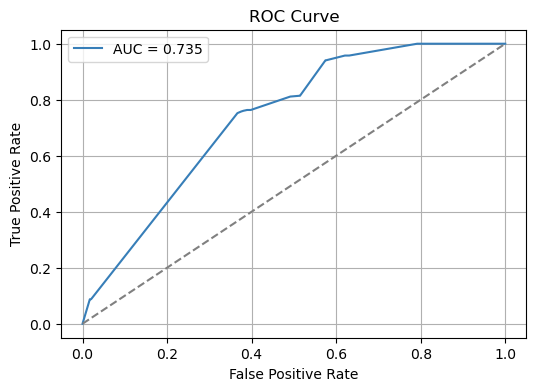

In [13]:
# Plot roc auc curve
fig_roc_auc_curve = Plot.plot_roc_auc(y_test, y_pred_prob)

**Summary:**

The model has a fair ability to classify positives and negatives, with an AUC of 0.735 indicating moderate predictive performance.